In [ ]:
!pip install CoolProp
!pip install pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.5 MB/s eta 0:00:00


In [ ]:
import CoolProp.CoolProp as CP
import numpy as np
import pyswarms as ps

# Valores fixados
refri1 = 'R123'  # Ciclo superior
refri2 = 'R600a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em Watts
delta_T = 5  # Diferença de temperatura no trocador cascata
T_cond = 50 + 273.15  # Temperatura de condensação
efi = 0.7 # Eficiência Isentrópica do Compressor
T_evap = -25 + 273.15 # Temperatura de evaporação

def calcular_COP_e_UA(P_sep, P_2):
    # Ponto 1
    h_1 = CP.PropsSI('H', 'T', T_evap, 'Q', 1, refri2)
    s_1 = CP.PropsSI('S', 'T', T_evap, 'Q', 1, refri2)

    # Ponto 2 (saída do compressor 1)
    h_2s = CP.PropsSI('H', 'P', P_2, 'S', s_1, refri2)
    h_2 = ((h_2s - h_1) / efi) + h_1
    Temperatura_2 = CP.PropsSI('T', 'P', P_2, 'H', h_2, refri2)
    s_2 = CP.PropsSI('S', 'P', P_2, 'H', h_2, refri2)

    # Ponto 3 (saída do trocador cascata)
    h_3 = CP.PropsSI('H', 'P', P_2, 'Q', 0, refri2)
    Temperatura_3 = CP.PropsSI('T', 'P', P_2, 'Q', 0, refri2)
    s_3 = CP.PropsSI('S', 'P', P_2, 'Q', 0, refri2)

    # Ponto 4 (saída da válvula inferior)
    h_4 = h_3

    # Ponto 5 (antes do comp2)
    Temperatura_5 = Temperatura_3 - delta_T
    h_5 = CP.PropsSI('H', 'T', Temperatura_5, 'Q', 1, refri1)
    P_5 = CP.PropsSI('P', 'T', Temperatura_5, 'Q', 1, refri1)
    s_5 = CP.PropsSI('S', 'T', Temperatura_5, 'Q', 1, refri1)

    # Ponto 6 (depois do trocador int do ciclo superior)
    P_6 = P_sep
    h_6s = CP.PropsSI('H', 'P', P_6, 'S', s_5, refri1)
    h_6 = ((h_6s - h_5) / efi) + h_5
    Temperatura_6 = CP.PropsSI('T', 'P', P_6, 'H', h_6, refri1)

    # Ponto 7 (saída do sep como líquido saturado)
    P_7 = P_6
    h_7 = CP.PropsSI('H', 'P', P_7, 'Q', 0, refri1)

    # Ponto 8 (saída da válvula 2)
    P_8 = P_5
    h_8 = h_7
    Temperatura_8 = CP.PropsSI('T', 'P', P_8, 'H', h_8, refri1)
    s_8 = CP.PropsSI('S', 'P', P_8, 'H', h_8, refri1)

    # Ponto 9 (entrada do compressor 3)
    P_9 = P_sep
    h_9 = CP.PropsSI('H', 'P', P_9, 'Q', 1, refri1)
    s_9 = CP.PropsSI('S', 'P', P_9, 'Q', 1, refri1)

    # Ponto 11 (saída do condensador)
    P_11 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
    h_11 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)

    # Ponto 10 (saída do compressor 3)
    P_10 = P_11
    h_10s = CP.PropsSI('H', 'P', P_10, 'S', s_9, refri1)
    h_10 = ((h_10s - h_9) / efi) + h_9

    # Ponto 12 (saída da válvula 3)
    h_12 = h_11

    # Cálculo das vazões mássicas
    m1 = carga_termica / (h_1 - h_4)
    m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))
    m3 = m2 * ((h_7 - h_6) / (h_12 - h_9))

    # Trabalhos e COP
    w1 = m1 * (h_2 - h_1)
    w2 = m2 * (h_6 - h_5)
    w3 = m3 * (h_10 - h_9)
    COP = carga_termica / (w1 + w2 + w3)

    # Cálculo da diferença de temperatura média logarítmica (LMTD)
    delta_T_m = (((Temperatura_2 - Temperatura_8) - (Temperatura_3 - Temperatura_5)) /
                 np.log((Temperatura_2 - Temperatura_8) / (Temperatura_3 - Temperatura_5)))

    # Cálculo de Q
    Q = m2 * (h_5 - h_8)

    # Cálculo de UA
    UA = Q / delta_T_m

    return COP, UA

# Função objetivo para o PSO
def funcao_objetivo(x):
    P_sep, P_2 = x[:, 0], x[:, 1]
    COP_valores = np.array([-calcular_COP_e_UA(P_sep[i], P_2[i])[0] for i in range(len(P_sep))])
    return COP_valores

# Restrições
Psep_min, Psep_max = 6747, 212462  # Limites para Psep
P2_min, P2_max = 58427, 750000    # Limites para P2

# Configuração do PSO
opcoes = {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
limites = (np.array([Psep_min, P2_min]), np.array([Psep_max, P2_max]))

# Execução do PSO
optimizer = ps.single.GlobalBestPSO(n_particles=30, dimensions=2, options=opcoes, bounds=limites)
melhor_custo, melhor_posicao = optimizer.optimize(funcao_objetivo, iters=70)

# Resultados
Psep_otimizado, P2_otimizado = melhor_posicao
COP_otimizado, UA_otimizado = calcular_COP_e_UA(Psep_otimizado, P2_otimizado)

print(f"Resultados ótimos:")
print(f"Psep = {Psep_otimizado / 1000:.2f} kPa")
print(f"P2 = {P2_otimizado / 1000:.2f} kPa")
print(f"COP máximo = {COP_otimizado:.4f}")
print(f"UA correspondente = {UA_otimizado:.4f} W/K")

2025-02-18 19:00:52,188 - pyswarms.single.global_best - INFO - Optimize for 70 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|70/70, best_cost=-1.85
2025-02-18 19:01:07,349 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8474162896313788, best pos: [ 85246.12410846 157688.87891275]


Resultados ótimos:
Psep = 85.25 kPa
P2 = 157.69 kPa
COP máximo = 1.8474
UA correspondente = 248.8968 W/K


In [ ]:
import CoolProp.CoolProp as CP
import numpy as np
import pyswarms as ps

# Valores fixados
refri1 = 'R123'  # Ciclo superior
refri2 = 'R600a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo superior (50°C)
efi = 0.7
T_evap = -25 + 273.15
P_sep = 85250
P_2 = 157690

# Dados do estado "0"
t0 = 30 + 273.15
h0_2 = CP.PropsSI('H', 'T', t0, 'P', 101325, refri2)
s0_2 = CP.PropsSI('S', 'T', t0, 'P', 101325, refri2)
h0_1 = CP.PropsSI('H', 'T', t0, 'P', 101325, refri1)
s0_1 = CP.PropsSI('S', 'T', t0, 'P', 101325, refri1)
tl = -16 + 273.15

# Ponto 1
h_1 = CP.PropsSI('H', 'T', T_evap, 'Q', 1, refri2)
s_1 = CP.PropsSI('S', 'T', T_evap, 'Q', 1, refri2)
P_1 = CP.PropsSI('P', 'T', T_evap, 'Q', 1, refri2)
af1 = (h_1 - h0_2) - (t0 * (s_1 - s0_2))

# Ponto 2 (saída do compressor 1)
h_2s = CP.PropsSI('H', 'P', P_2, 'S', s_1, refri2)
h_2 = ((h_2s - h_1) / efi) + h_1
Temperatura_2 = CP.PropsSI('T', 'P', P_2, 'H', h_2, refri2)
s_2 = CP.PropsSI('S', 'P', P_2, 'H', h_2, refri2)
af2 = (h_2 - h0_2) - (t0 * (s_2 - s0_2))

# Ponto 3 (saída do trocador cascata)
h_3 = CP.PropsSI('H', 'P', P_2, 'Q', 0, refri2)
Temperatura_3 = CP.PropsSI('T', 'P', P_2, 'Q', 0, refri2)
s_3 = CP.PropsSI('S', 'P', P_2, 'Q', 0, refri2)
af3 = (h_3 - h0_2) - (t0 * (s_3 - s0_2))

# Ponto 4 (saída da válvula inferior)
h_4 = h_3
Temperatura_4 = CP.PropsSI('T', 'P', P_1, 'H', h_4, refri2)
s_4 = CP.PropsSI('S', 'P', P_1, 'H', h_4, refri2)
af4 = (h_4 - h0_2) - (t0 * (s_4 - s0_2))
x4 = CP.PropsSI('Q', 'P', P_1, 'H', h_4, refri2)

# Ponto 5 (antes do comp2)
Temperatura_5 = Temperatura_3 - delta_T
h_5 = CP.PropsSI('H', 'T', Temperatura_5, 'Q', 1, refri1)
P_5 = CP.PropsSI('P', 'T', Temperatura_5, 'Q', 1, refri1)
s_5 = CP.PropsSI('S', 'T', Temperatura_5, 'Q', 1, refri1)
af5 = (h_5 - h0_1) - (t0 * (s_5 - s0_1))

# Ponto 6
P_6 = P_sep
h_6s = CP.PropsSI('H', 'P', P_6, 'S', s_5, refri1)
h_6 = ((h_6s - h_5) / efi) + h_5
Temperatura_6 = CP.PropsSI('T', 'P', P_6, 'H', h_6, refri1)
s_6 = CP.PropsSI('S', 'P', P_6, 'H', h_6, refri1)
af6 = (h_6 - h0_1) - (t0 * (s_6 - s0_1))

# Ponto 7 (saída do sep como líquido saturado)
P_7 = P_6
h_7 = CP.PropsSI('H', 'P', P_7, 'Q', 0, refri1)
s_7 = CP.PropsSI('S', 'P', P_7, 'H', h_7, refri1)
af7 = (h_7 - h0_1) - (t0 * (s_7 - s0_1))

# Ponto 8 (saída da válvula 2)
P_8 = P_5
h_8 = h_7
Temperatura_8 = CP.PropsSI('T', 'P', P_8, 'H', h_8, refri1)
s_8 = CP.PropsSI('S', 'P', P_8, 'H', h_8, refri1)
af8 = (h_8 - h0_1) - (t0 * (s_8 - s0_1))
x8 = CP.PropsSI('Q', 'P', P_8, 'H', h_8, refri1)

# Ponto 9
P_9 = P_sep
h_9 = CP.PropsSI('H', 'P', P_9, 'Q', 1, refri1)
s_9 = CP.PropsSI('S', 'P', P_9, 'Q', 1, refri1)
af9 = (h_9 - h0_1) - (t0 * (s_9 - s0_1))

# Ponto 11
P_11 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
h_11 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)
s_11 = CP.PropsSI('S', 'T', T_cond, 'Q', 0, refri1)
af11 = (h_11 - h0_1) - (t0 * (s_11 - s0_1))

# Ponto 10
P_10 = P_11
h_10s = CP.PropsSI('H', 'P', P_10, 'S', s_9, refri1)
h_10 = ((h_10s - h_9) / efi) + h_9
s_10 = CP.PropsSI('S', 'P', P_10, 'H', h_10, refri1)
af10 = (h_10 - h0_1) - (t0 * (s_10 - s0_1))

# Ponto 12
h_12 = h_11
s_12 = CP.PropsSI('S', 'P', P_sep, 'H', h_12, refri1)
af12 = (h_12 - h0_1) - (t0 * (s_12 - s0_1))
x12 = CP.PropsSI('Q', 'P', P_sep, 'H', h_12, refri1)

# Cálculo das vazões mássicas
m1 = carga_termica / (h_1 - h_4)
m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))
m3 = m2 * ((h_7 - h_6) / (h_12 - h_9))

# Trabalhos e COP
w1 = m1 * (h_2 - h_1)
w2 = m2 * (h_6 - h_5)
w3 = m3 * (h_10 - h_9)
COP = carga_termica / (w1 + w2 + w3)

# Cálculo da diferença de temperatura média logarítmica (LMTD)
delta_T_m = (((Temperatura_2 - Temperatura_8) - (Temperatura_3 - Temperatura_5)) / np.log((Temperatura_2 - Temperatura_8) / (Temperatura_3 - Temperatura_5)))

# Exergias
ADComp1 = (m1*af1)+w1-(m1*af2)
ADValv1 = (m1*af3)-(m1*af4)
ADEvap = (m1*af4)+(carga_termica*(1-(t0/tl)))-(m1*af1)
ADTrocCasc = (m1*(af2-af3))+(m2*(af8-af5))
ADComp2 = (m2*af5)+w2-(m2*af6)
ADValv2 = (m2*af7)-(m2*af8)
ADSep = (m2*(af6-af7))+(m3*(af12-af9))
ADComp3 = (m3*af9)+w3-(m3*af10)
ADValv3 = (m3*af11)-(m3*af12)
ADCond = (m3*af10)-(m3*af11)

# Informações do ciclo
ADTotal = (w1+w2+w3)+(carga_termica*(1-(t0/tl)))
th = t0
COPteorico = tl / (th - tl)
N2 = COP / COPteorico

# Cálculo de Q
Q = m2 * (h_5 - h_8)

# Cálculo de UA
UA = Q / delta_T_m

print(P_11)

212462.92691840156


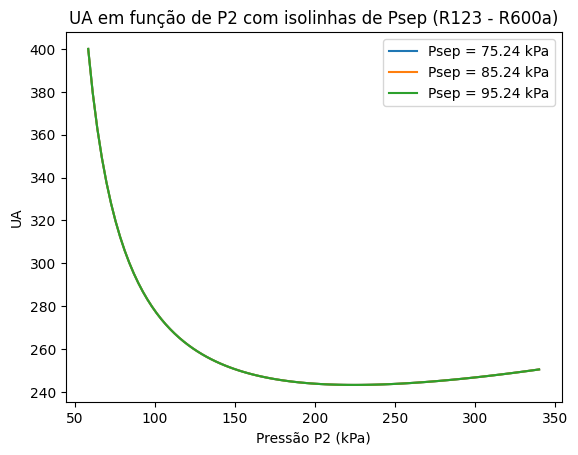

In [ ]:
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import numpy as np

# Valores fixados
refri1 = 'R123'  # Ciclo superior
refri2 = 'R600a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo superior (50°C)
efi = 0.7
T_evap = -25 + 273.15

# Valores de Psep para as isolinhas em Pa
valores_de_Psep = [75240, 85240, 95240]

# Intervalo de valores de P6 para o gráfico em Pa
valores_de_P2 = np.linspace(58427, 340000, 100)

# Loop sobre os valores de Psep (para as isolinhas)
for P_sep in valores_de_Psep:
    valores_UA = []
    pressoes_p2 = []
    for P_2 in valores_de_P2:
      # Ponto 1
      h_1 = CP.PropsSI('H', 'T', T_evap, 'Q', 1, refri2)
      s_1 = CP.PropsSI('S', 'T', T_evap, 'Q', 1, refri2)
      P_1 = CP.PropsSI('P', 'T', T_evap, 'Q', 1, refri2)

      # Ponto 2 (saída do compressor 1)
      h_2s = CP.PropsSI('H', 'P', P_2, 'S', s_1, refri2)
      h_2 = ((h_2s - h_1) / efi) + h_1
      Temperatura_2 = CP.PropsSI('T', 'P', P_2, 'H', h_2, refri2)
      s_2 = CP.PropsSI('S', 'P', P_2, 'H', h_2, refri2)

      # Ponto 3 (saída do trocador cascata)
      h_3 = CP.PropsSI('H', 'P', P_2, 'Q', 0, refri2)
      Temperatura_3 = CP.PropsSI('T', 'P', P_2, 'Q', 0, refri2)
      s_3 = CP.PropsSI('S', 'P', P_2, 'Q', 0, refri2)

      # Ponto 4 (saída da válvula inferior)
      h_4 = h_3
      Temperatura_4 = CP.PropsSI('T', 'P', P_1, 'H', h_4, refri2)
      s_4 = CP.PropsSI('S', 'P', P_1, 'H', h_4, refri2)

      # Ponto 5 (antes do comp2)
      Temperatura_5 = Temperatura_3 - delta_T
      h_5 = CP.PropsSI('H', 'T', Temperatura_5, 'Q', 1, refri1)
      P_5 = CP.PropsSI('P', 'T', Temperatura_5, 'Q', 1, refri1)
      s_5 = CP.PropsSI('S', 'T', Temperatura_5, 'Q', 1, refri1)

      # Ponto 6
      P_6 = P_sep
      h_6s = CP.PropsSI('H', 'P', P_6, 'S', s_5, refri1)
      h_6 = ((h_6s - h_5) / efi) + h_5
      Temperatura_6 = CP.PropsSI('T', 'P', P_6, 'H', h_6, refri1)
      s_6 = CP.PropsSI('S', 'P', P_6, 'H', h_6, refri1)

      # Ponto 7 (saída do sep como líquido saturado)
      P_7 = P_6
      h_7 = CP.PropsSI('H', 'P', P_7, 'Q', 0, refri1)
      s_7 = CP.PropsSI('S', 'P', P_7, 'H', h_7, refri1)

      # Ponto 8 (saída da válvula 2)
      P_8 = P_5
      h_8 = h_7
      Temperatura_8 = CP.PropsSI('T', 'P', P_8, 'H', h_8, refri1)
      s_8 = CP.PropsSI('S', 'P', P_8, 'H', h_8, refri1)
      x8 = CP.PropsSI('Q', 'P', P_8, 'H', h_8, refri1)

      # Ponto 9
      P_9 = P_sep
      h_9 = CP.PropsSI('H', 'P', P_9, 'Q', 1, refri1)
      s_9 = CP.PropsSI('S', 'P', P_9, 'Q', 1, refri1)

      # Ponto 11
      P_11 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
      h_11 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)
      s_11 = CP.PropsSI('S', 'T', T_cond, 'Q', 0, refri1)

      # Ponto 10
      P_10 = P_11
      h_10s = CP.PropsSI('H', 'P', P_10, 'S', s_9, refri1)
      h_10 = ((h_10s - h_9) / efi) + h_9
      s_10 = CP.PropsSI('S', 'P', P_10, 'H', h_10, refri1)

      # Ponto 12
      h_12 = h_11
      s_12 = CP.PropsSI('S', 'P', P_sep, 'H', h_12, refri1)

      # Cálculo das vazões mássicas
      m1 = carga_termica / (h_1 - h_4)
      m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))
      m3 = m2 * ((h_7 - h_6) / (h_12 - h_9))

      # Trabalhos e COP
      w1 = m1 * (h_2 - h_1)
      w2 = m2 * (h_6 - h_5)
      w3 = m3 * (h_10 - h_9)
      COP = carga_termica / (w1 + w2 + w3)

      # Cálculo da diferença de temperatura média logarítmica (LMTD)
      delta_T_m = (((Temperatura_2 - Temperatura_8) - (Temperatura_3 - Temperatura_5)) / np.log((Temperatura_2 - Temperatura_8) / (Temperatura_3 - Temperatura_5)))

      # Cálculo de Q
      Q = m2 * (h_5 - h_8)

      # Cálculo de UA
      UA = Q / delta_T_m

      # Armazenar os resultados para plotagem
      valores_UA.append(UA)
      pressoes_p2.append(P_2 / 1e3)

     # Plotar o gráfico UA x P2 para cada valor de Psep
    plt.plot(pressoes_p2, valores_UA, label=f'Psep = {P_sep / 1e3} kPa')

# Configurações do gráfico
plt.xlabel('Pressão P2 (kPa)')
plt.ylabel('UA')
plt.title('UA em função de P2 com isolinhas de Psep (R123 - R600a)')
plt.legend()
plt.grid(False)
plt.show()

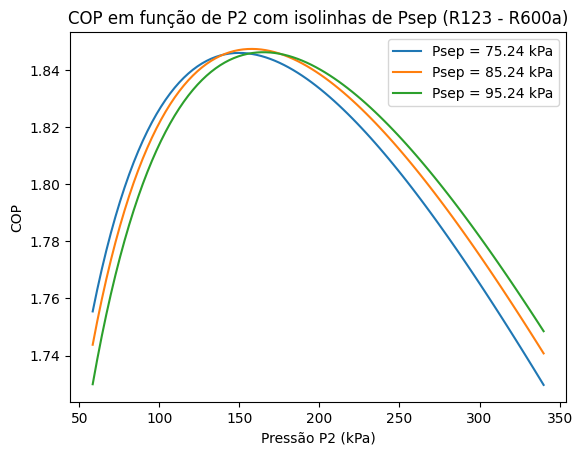

In [ ]:
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import numpy as np

# Valores fixados
refri1 = 'R123'  # Ciclo superior
refri2 = 'R600a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo 1 (50°C)
efi = 0.7
T_evap = -25 + 273.15

# Valores de Psep para as isolinhas em Pa
valores_de_Psep = [75240, 85240, 95240]

# Intervalo de valores de P6 para o gráfico em Pa
valores_de_P2 = np.linspace(58427, 340000, 100)

# Loop sobre os valores de Psep (para as isolinhas)
for P_sep in valores_de_Psep:
    valores_COP = []
    pressoes_p2 = []
    for P_2 in valores_de_P2:
      # Ponto 1
      h_1 = CP.PropsSI('H', 'T', T_evap, 'Q', 1, refri2)
      s_1 = CP.PropsSI('S', 'T', T_evap, 'Q', 1, refri2)
      P_1 = CP.PropsSI('P', 'T', T_evap, 'Q', 1, refri2)

      # Ponto 2 (saída do compressor 1)
      h_2s = CP.PropsSI('H', 'P', P_2, 'S', s_1, refri2)
      h_2 = ((h_2s - h_1) / efi) + h_1
      Temperatura_2 = CP.PropsSI('T', 'P', P_2, 'H', h_2, refri2)
      s_2 = CP.PropsSI('S', 'P', P_2, 'H', h_2, refri2)

      # Ponto 3 (saída do trocador cascata)
      h_3 = CP.PropsSI('H', 'P', P_2, 'Q', 0, refri2)
      Temperatura_3 = CP.PropsSI('T', 'P', P_2, 'Q', 0, refri2)
      s_3 = CP.PropsSI('S', 'P', P_2, 'Q', 0, refri2)

      # Ponto 4 (saída da válvula inferior)
      h_4 = h_3
      Temperatura_4 = CP.PropsSI('T', 'P', P_1, 'H', h_4, refri2)
      s_4 = CP.PropsSI('S', 'P', P_1, 'H', h_4, refri2)

      # Ponto 5 (antes do comp2)
      Temperatura_5 = Temperatura_3 - delta_T
      h_5 = CP.PropsSI('H', 'T', Temperatura_5, 'Q', 1, refri1)
      P_5 = CP.PropsSI('P', 'T', Temperatura_5, 'Q', 1, refri1)
      s_5 = CP.PropsSI('S', 'T', Temperatura_5, 'Q', 1, refri1)

      # Ponto 6
      P_6 = P_sep
      h_6s = CP.PropsSI('H', 'P', P_6, 'S', s_5, refri1)
      h_6 = ((h_6s - h_5) / efi) + h_5
      Temperatura_6 = CP.PropsSI('T', 'P', P_6, 'H', h_6, refri1)
      s_6 = CP.PropsSI('S', 'P', P_6, 'H', h_6, refri1)

      # Ponto 7 (saída do sep como líquido saturado)
      P_7 = P_6
      h_7 = CP.PropsSI('H', 'P', P_7, 'Q', 0, refri1)
      s_7 = CP.PropsSI('S', 'P', P_7, 'H', h_7, refri1)

      # Ponto 8 (saída da válvula 2)
      P_8 = P_5
      h_8 = h_7
      Temperatura_8 = CP.PropsSI('T', 'P', P_8, 'H', h_8, refri1)
      s_8 = CP.PropsSI('S', 'P', P_8, 'H', h_8, refri1)

      # Ponto 9
      P_9 = P_sep
      h_9 = CP.PropsSI('H', 'P', P_9, 'Q', 1, refri1)
      s_9 = CP.PropsSI('S', 'P', P_9, 'Q', 1, refri1)

      # Ponto 11
      P_11 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
      h_11 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)
      s_11 = CP.PropsSI('S', 'T', T_cond, 'Q', 0, refri1)

      # Ponto 10
      P_10 = P_11
      h_10s = CP.PropsSI('H', 'P', P_10, 'S', s_9, refri1)
      h_10 = ((h_10s - h_9) / efi) + h_9
      s_10 = CP.PropsSI('S', 'P', P_10, 'H', h_10, refri1)

      # Ponto 12
      h_12 = h_11
      s_12 = CP.PropsSI('S', 'P', P_sep, 'H', h_12, refri1)

      # Cálculo das vazões mássicas
      m1 = carga_termica / (h_1 - h_4)
      m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))
      m3 = m2 * ((h_7 - h_6) / (h_12 - h_9))

      # Trabalhos e COP
      w1 = m1 * (h_2 - h_1)
      w2 = m2 * (h_6 - h_5)
      w3 = m3 * (h_10 - h_9)
      COP = carga_termica / (w1 + w2 + w3)

      # Armazenar os resultados para plotagem
      valores_COP.append(COP)
      pressoes_p2.append(P_2 / 1e3)  # Convertendo P6 para kPa

    # Plotar o gráfico UA x P2 para cada valor de Psep
    plt.plot(pressoes_p2, valores_COP, label=f'Psep = {P_sep / 1e3} kPa')

# Configurações do gráfico
plt.xlabel('Pressão P2 (kPa)')
plt.ylabel('COP')
plt.title('COP em função de P2 com isolinhas de Psep (R123 - R600a)')
plt.legend()
plt.grid(False)
plt.show()